In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
import math
from queue import PriorityQueue

In [12]:
def givemedag(v,e,c):
    if e < v-1:
        print('边太少')
        return None
    #e大小要适量
    D = nx.DiGraph()
    leaves=[]
    while(True):
        nx.generators.directed.gn_graph(v-1,kernel = lambda x :x**c,create_using = D)
        tmp = [x[0] for x in list(D.in_degree()) if x[1] == 0]
        leafnum = len(tmp)
        if D.number_of_edges() + leafnum <= e:
            leaves = tmp.copy()
            break
    #nx.draw(D,with_labels=True)
    
    my_dict = nx.shortest_path_length(nx.reverse_view(D),source=0)
    mylst = list(zip(my_dict.values(), my_dict.keys()))
    #print(my_dict)
    #print(mylst)
    #print(leaves)
    D.add_node(v-1)
    for each in leaves:
        fea = [x[1] for x in mylst if x[0]>my_dict[each]]
        fea.append(v-1)
        D.add_edge(random.choice(fea),each)
    return D.reverse()

In [23]:
def givemeagent(E, C,var):
    agents = {}
    for e in E:
        ci = np.random.randint(1,C)
        agents[e]=[]
        for i in range(ci):
            bi = -1
            while bi < 0:
                bi = np.random.normal(50,math.sqrt(var))
            ti = -1
            while ti <0:
                ti = np.random.randint(1,100)
            agents[e].append((bi,ti,e,i))
    return agents

In [4]:
def reweight(dag,agentinfo):
    for e in list(dag.edges):
        dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]

In [5]:
def allocation2(dag,agentinfo,timelimit):
    #basebid = {}
    relativebid = [(agentinfo[e][i][0]-agentinfo[e][0][0],agentinfo[e][i][1],agentinfo[e][i][2],agentinfo[e][i][3])for e in list(dag.edges)for i in range(1,len(agentinfo[e]))]
    #print('#')
    #print(relativebid)
    #print('#')
    ansdict = {}
    reweight(dag,agentinfo)
    for e in list(dag.edges):
        #dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        ansdict[e] = 0
    #print(relativebid)
    #if nx.dag_longest_path_length(dag) > timelimit:
    #    print('mission impossible')
    #    return -1
    vis = {}
    relativebid.sort(key = lambda x:x[0])
    while relativebid != []:
        if len(vis) == dag.number_of_edges():
            break
        item = relativebid.pop()
        #print('$')
        #print(item)
        if item[2] in vis:
            continue
        tmp = dag.edges[item[2][0],item[2][1]]['weight']
        dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
        if nx.dag_longest_path_length(dag) > timelimit:
            dag.edges[item[2][0],item[2][1]]['weight'] = tmp
            continue
        vis[item[2]] = True
        #print(e)
        #print(item[3])
        ansdict[item[2]] = item[3]
    return ansdict

In [6]:
def init(dag,agentinfo):
    for e in list(dag.edges):
        agentinfo[e].sort(key=lambda x:x[0],reverse=True)
        agentinfo[e].sort(key = lambda x:x[1]) 
        nowbid = agentinfo[e][0][0]
        tmp = [(agentinfo[e][0][0],agentinfo[e][0][1],agentinfo[e][0][2],0)]
        for i in range(1,len(agentinfo[e])):
            if agentinfo[e][i][0] > nowbid:
                nowbid = agentinfo[e][i][0]
                lens = len(tmp)
                tmp.append((agentinfo[e][i][0],agentinfo[e][i][1],agentinfo[e][i][2],lens))
        agentinfo[e] = tmp

In [7]:
def graphseq(dag,agentinfo,e,ind,relativebid,timelimit):
    reweight(dag,agentinfo)
    #cong tou qu 
    relativebid.sort(key = lambda x:x[0])
    vis = {}
    if ind > 0:
        sign = False
        addon = agentinfo[e][ind-1][0]-agentinfo[e][0][0]
        
        while relativebid != []:
            item = relativebid.pop()
            if item[2] in vis:
                continue
            if item[2] == e:
                if item[0] <= addon:
                    break
                else:
                    if item[3] == ind:
                        sign=True
                    continue
            tmp = dag.edges[item[2][0],item[2][1]]['weight']
            dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
            if nx.dag_longest_path_length(dag) > timelimit:
                dag.edges[item[2][0],item[2][1]]['weight'] = tmp
                continue
            vis[item[2]] = True
            if sign:
                dag.edges[e[0],e[1]]['weight'] = agentinfo[e][ind][1]
                if nx.dag_longest_path_length(dag) > timelimit:
                    addon = max(addon,item[0])
                    break
                dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        #print(e,1,addon+agentinfo[e][0][0])
        return addon+agentinfo[e][0][0]
    else:
        if len(agentinfo[e]) == 1:
            #print(e,0,0)
            return 0
        graphs=[dag.copy()]
        bids=[0]
        que = PriorityQueue()
        while relativebid != []:
            item = relativebid.pop()
            if item[0] < agentinfo[e][1][0]:
                break
            if item[2] in vis:
                continue
            if item[2] == e:
                pre = len(bids)-1
                if pre > 0:
                    que.put((bids[pre]-item[0],pre,item[3]))
                continue
            tmp = dag.edges[item[2][0],item[2][1]]['weight']
            dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
            if nx.dag_longest_path_length(dag) > timelimit:
                dag.edges[item[2][0],item[2][1]]['weight'] = tmp
                continue
            vis[item[2]] = True
            graphs.append(dag.copy())
            bids.append(item[0])
        acc = 0 #crucial
        addons = -1
        while not que.empty():
            front = que.get()
            if front[1] >= 1:
                delta = bids[front[1]]-(agentinfo[e][front[2]][0] + acc)
                acc = acc + delta
                if acc >= agentinfo[e][0][0]:
                    break
                newdist = max(0,bids[front[1]-1]-bids[front[1]])+ delta
                que.put((newdist,front[1]-1,front[2]))
            prepos = front[1]
            myind = front[2]
            graphs[prepos].edges[e[0],e[1]]['weight'] = agentinfo[e][myind][1]
            if nx.dag_longest_path_length(graphs[prepos]) <= timelimit: 
                addons = bids[prepos+1]-agentinfo[e][myind][0]
                break
            graphs[prepos].edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        if addons == -1:
            #print(e,0,0)
            return 0
        #print(e,0,agentinfo[e][0][0]-addons)
        return agentinfo[e][0][0]-addons

In [8]:
def payment(dag,agentinfo,timelimit):
    
    relativebid = [(agentinfo[e][i][0]-agentinfo[e][0][0],agentinfo[e][i][1],agentinfo[e][i][2],agentinfo[e][i][3])for e in list(dag.edges)for i in range(1,len(agentinfo[e]))]
    allo = allocation2(dag,agentinfo,timelimit)
    #print(allo)
    ans = 0.0
    for e in list(dag.edges):
        ans = ans + graphseq(dag,agentinfo,e,allo[e],relativebid,timelimit)
    #print(ans)
    return ans

In [21]:
def checkpay(n,C,kernel,var):
    #n=200
    #C=3
    aoe = givemedag(n,1000000000,kernel)
    assert nx.is_directed_acyclic_graph(aoe)
    #print(aoe.number_of_edges())
    #nx.draw(aoe,with_labels=True)
    es = list(aoe.edges)
    agents = givemeagent(es,C,var)
    init(aoe,agents)
    #print(agents)
    ms = {}
    for e in es:
        ms[e] = (agents[e][0][1],agents[e][len(agents[e])-1][1])
    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][0]
    a = nx.dag_longest_path_length(aoe)

    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][1]
    b = nx.dag_longest_path_length(aoe)
    #print(a,b)
    tl = np.random.randint(a,b+1)
    #payment(aoe,agents,tl)
    return payment(aoe,agents,tl)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


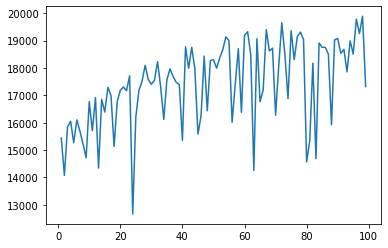

In [28]:
y = []
x = range(1,100)
for u in x:
    print(u)
    y.append(checkpay(200,100,1,u))
#y=[checkpay(u,100)for u in x]

plt.plot(x,y)

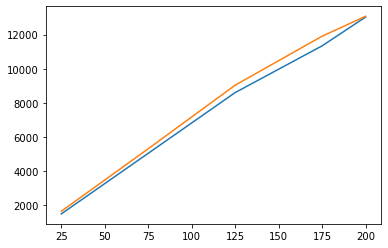

In [34]:
x=[25,75,125,175,200]
y=[1478.312,5037.261,8599.328,11341.959,13031.76]
y2=[1632.41,5302.871,9032.998,11707.221,13076.298]
plt.plot(x,y)
plt.plot(x,y2)

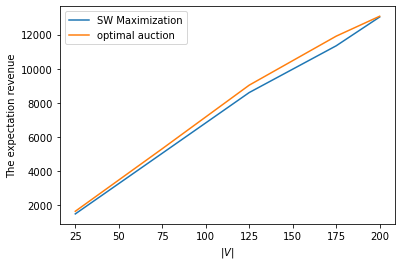

In [36]:

plt.xlabel('$|V|$')
plt.ylabel('The expectation revenue')

#plt.xlabel('The variance of bids distribution')
#plt.ylabel('Expectation Revenue')

plt.plot(x,y,label="SW Maximization")
plt.plot(x,y2,label="optimal auction")
plt.legend()
plt.savefig('expswandoptimal.pdf')
plt.show()